# Data Cleaning

### Import Packages

In [2]:
# Load Data Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

### Read excel data into dataframe (df)

In [3]:
# Full Dataset
df = pd.read_excel(r"C:\Users\mlyman\Desktop\NYC Data Science\Python Project\Source Data\Shark Tank Investments.xlsx", 
                   sheet_name="Company Detail")

### Reshape & Clean

Transpose investor names into single column

In [3]:
df = pd.melt(df, id_vars = ['Company ','Season', 'Investment (yes or no)', 'Investment amount','Type of investment',
                       'Company status', 'Company industry', 'Deal Closed'])

Rename & clean column headers

In [4]:
# strip leading/trailing spaces and set all to lowercase
df.columns = map(str.strip, map(str.lower, df.columns))

In [5]:
# rename variables for clarity & easier querying
df.rename(columns = {'variable':'shark', 
                     'investment (yes or no)': 'invested?',
                     'type of investment':'investment_type'}, inplace = True)

Remove Leading/Trailing Spaces from shark names

In [6]:
# strip leading/trailing spaces from investor names
df['shark'] = df['shark'].str.strip().str.replace('.','')


C:\Users\mlyman\AppData\Local\Temp\ipykernel_25064\3678196618.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['shark'] = df['shark'].str.strip().str.replace('.','')


Clean up "company status" column

In [7]:
# set all to lowercase
df["company status"] = df["company status"].str.lower()

# rename "out of business" to "closed"
df["company status"] = df["company status"].replace({'out of business':'closed'})

# Review summary
df["company status"].unique()

array(['existing', nan, 'closed', 'sold', 'acquired'], dtype=object)

### Add Additional Datapoints

##### Core Sharks

These are the primary/recurring investors on the show:
- Barbara Corcoran: "Barbara"
- Daymond John: "Daymond"
- Robert Herjavec: "Robert"
- Kevin O'Leary: "Kevin O"
- Mark Cuban: "Mark"
- Lori Greiner: "Lori"

In [8]:
df['core_shark'] = df['shark'].isin(['Daymond', 'Barbara', 'Robert', 'Kevin O', 'Mark','Lori'])

In [9]:
# Review list
print(df[df['core_shark'] == True]['shark'].unique())

['Daymond' 'Barbara' 'Robert' 'Kevin O' 'Mark' 'Lori']


##### Year
Year that season ended (season 1 ended in 2010)

In [10]:
# Create "get_year" function
def get_year(season):
    return 2010 + (season - 1) # count up by season number minus one (i.e. Season 3 = 2010 + 3 -1 = 2012)

# Apply get_year to identify the year each season ended
df['year'] = df['season'].apply(get_year)

##### Count
Each row represents 1 investment for each shark. Sum of count results in total investments made. 

Note: more than one shark can invest in a deal. Therefore investments made does not always equal companies invested in. 

In [11]:
df['count'] = 1

##### Values in Thousands (K) and Millions (M)

In [12]:
df["value_k"] = df["value"]/1000
df["value_m"] = df["value"]/1000000

# Create "core_df" dataframe

Core dataframe only contains investments by core sharks

Does not contain rows with:
- guest sharks
- zero or null investment amounts

In [13]:
# filter for core sharks
core_df = df[df['core_shark'] == True]

# remove rows from core_df where values are null or zero (no investment made)
core_df = core_df[(core_df['value'].notnull()) & (core_df['value'] != 0)]

# Investments by Industry

The top 10 indsutries, by number of investments, for reference

In [14]:
industry_count = core_df.pivot_table(index = 'company industry', values = 'count', aggfunc = sum)
industry_count.sort_values(by=['count'], ascending=False).head(10)

,count
company industry,
Food and Beverage,180
Fashion or clothing,98
Kid products,83
Health,77
Home,66
Outdoors,37
Pet products,36
Entertainment,35
Exercise,32


# "select_industry" Function
Function tailors subsequent charts and tables for selected industry. Steps are as follows:
- User inputs the industry they would like to analyze, or inputs "All" to view all industries
- The function checks to see if the industry is listed in the "core_df" dataframe
   - If the industry is NOT valid, it returns an error with a list of industries
   - If the industry is valid, it updates the industry_df dataframe and confirms selection
- Subsequent graphs reference industry_df for builds

In [49]:
# Create function that confirms selection and updates global variable "industry_selected" for subsequent analysis
def select_industry(selection):
    
    # Enable global variables
    global industry_selected
    global industry_df
    
    # Generate Industry List
    industry_list = list(set(core_df["company industry"]))
    
    # If "selection" = "All", use core_df (containing all industries)
    if selection == "All":
        industry_df = core_df[(core_df["deal closed"] == "y")]
        industry_selected = selection  # Update global value so user can confirm
        return selection + " industries will be incorporated into analysis"
    
    # If selection is not all and is valid industry, filter database for related industry
    elif selection in industry_list:
        industry_selected = selection
        industry_df = core_df[(core_df["company industry"] == industry_selected) & (core_df["deal closed"] == "y")]
        
        return "The industry selected is " + selection
   
    #If not valid, return error with options to select from
    else:
        return "ERROR: "+selection+" is not found. Available industries are: All, " + str(industry_list)

In [51]:
# Test invalid industry
select_industry("test")

"ERROR: test is not found. Available industries are: All, ['Tools', 'Pet products', 'Delivery service', 'Gifts', 'Art', 'Transportation', 'Automotive', 'Retail', 'Decoration', 'Safety and Security', 'Business', 'Productivity', 'Tech', 'Lifestyle', 'Construction', 'Kid products', 'Home', 'Entertainment', 'Education', 'Social', 'Travel', 'Rental', 'Health', 'Outdoors', 'Fashion or clothing', 'Music', 'Exercise', 'Food and Beverage', 'Organization', 'Gardening', 'Technology', 'Cleaning', 'Furniture']"

In [52]:
# Test valid industry
select_industry("Food and Beverage")

'The industry selected is Food and Beverage'

In [53]:
# Test All
select_industry("All")

'All industries will be incorporated into analysis'

# Industry Specific Analysis
Select an industry using the "select_industry" function.

The database will be filtered for:
- Company Industry = selection
- Deal Closed = "y"
    - Deals can come to an agreement on the show, but the owner can still back out backstage
    - I will make the assumption that the deal will close, and want to understand success rates among this population

In [54]:
select_industry("All")

'All industries will be incorporated into analysis'

### Investment Sizes

In [55]:
# Histogram of all investments since season 1
px.histogram(industry_df, 
                   x="value_k", 
                   y="count", 
                   title = "Histogram of Investments ("+industry_selected+")"
             
).update_layout(xaxis_title = "Investment Size (per shark)").show()

In [56]:
# Histogram of all investments under $1M
under1m_df = industry_df[industry_df['value'] < 1000000]

px.histogram(under1m_df, 
                   x="value_k", 
                   y="count", 
                   title = "Histogram of Investments under $1M ("+industry_selected+")"
            ).update_layout(xaxis_title = "Investment Size (per shark)"
            ).show()

In [66]:
px.histogram(under1m_df, 
             x="value_k", 
             y="count",
             title = "Histogram of Investments under $1M, by Investment Type & Shark ("+industry_selected+")",
             color = "investment_type",
             #facet_row = "shark",
             height = 500
            ).update_layout(xaxis_title = "Investment Size"
            ).show()

In [58]:
# This function creates a heat map based on the metric and aggregation defined

def heat_shark_season(metric, agg_method):
    # Create pivot table of defined metrics with sharks on x-axis and season on y
    heat_investments = industry_df.pivot_table(index='season', columns='shark', values=metric, aggfunc=agg_method)
    
    # Order investors (more active to least active)
    heat_investments = heat_investments[['Mark', 'Lori', 'Barbara', 'Robert', 'Daymond', 'Kevin O']]
    
    # format colors of heatmap
    sns.heatmap(heat_investments, annot=True, cmap='Greens'
               ).set(title = (agg_method+" of "+metric+" ("+industry_selected+")").title())
    plt.show()

## Who makes the most investments?

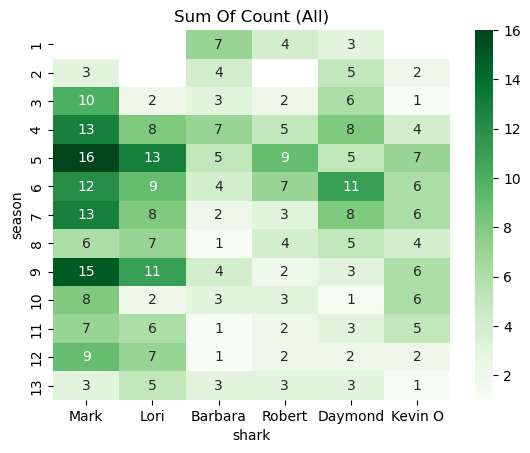

In [59]:
heat_shark_season("count", 'sum')

## Who invests the most dollars each season?

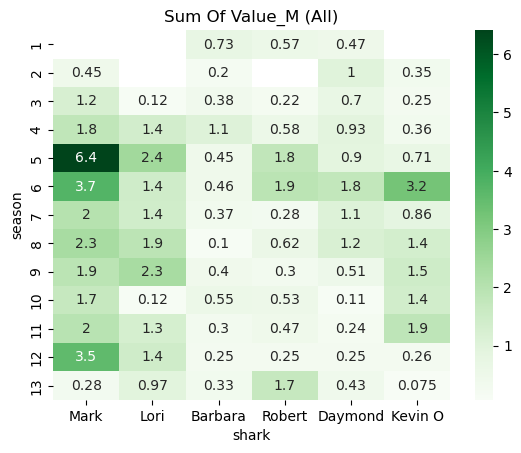

In [60]:
heat_shark_season("value_m",'sum')

## Who invests the most per deal?

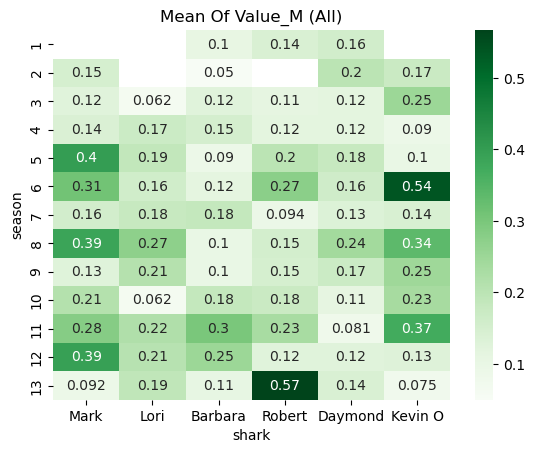

In [61]:
heat_shark_season("value_m",'mean')

## Who makes the largest investment each season?

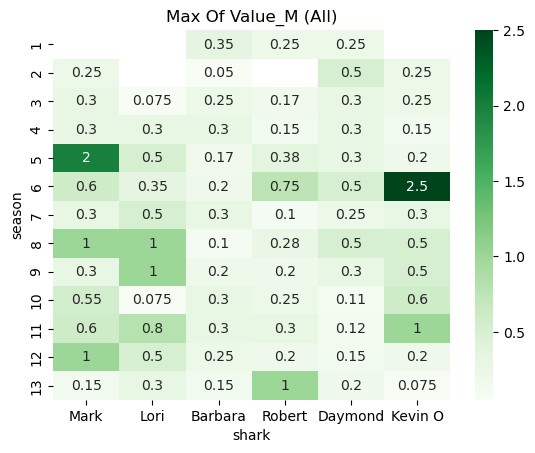

In [62]:
heat_shark_season("value_m",'max')

## Success Rates
While you want to optimize your chances of obtaining an investment, you'll also want to avoid sharks with a track record of failed investements or taking ownership of the business. 

This code summarizes the company status for each shark's investments. It performs the following:
- Count of company status (columns) by shark (rows)
- Populates any columns that may be missing (i.e. this industry didn't have any companies 'sold')
- Calculates a total column used to calculate ratios
- Calculates success rates (existing/sold/acquired), existing rate (excludes sold/acquired), and lost ownership (sold/acquired)

In [63]:
# Create Table of Status by Shark
success_pivot = industry_df.pivot_table(index="shark", columns='company status', values="count", aggfunc=sum)

# Replace NA with zero
success_pivot = success_pivot.fillna(0)

# Create all possible columns if missing
if 'acquired' not in success_pivot.columns:
    success_pivot = success_pivot.assign(acquired=0)
    
if 'existing' not in success_pivot.columns:
    success_pivot = success_pivot.assign(existing=0)
    
if 'closed' not in success_pivot.columns:
    success_pivot = success_pivot.assign(closed=0)
    
if 'sold' not in success_pivot.columns:
    success_pivot = success_pivot.assign(sold=0)


# Calculate a Total Column
success_pivot["total"] = (success_pivot["acquired"]+success_pivot["existing"]
                           +success_pivot["closed"]+success_pivot["sold"])

# Calculate Success Rate (% of businesses that are not "closed")
success_pivot["success rate"] = ((success_pivot["total"]-success_pivot["closed"])/success_pivot["total"]).round(2)

# Calculate Existing Rate (not sold, acquired, or out of business)
success_pivot["existing rate"] = (success_pivot["existing"]/success_pivot["total"]).round(2)

# Calculate Lost Ownership (sold or acquired)
success_pivot["lost ownership"] = ((success_pivot["total"]-success_pivot["existing"])/success_pivot["total"]).round(2)

success_pivot

company status,acquired,closed,existing,sold,total,success rate,existing rate,lost ownership
shark,,,,,,,,
Barbara,0.0,11.0,32.0,2.0,45.0,0.76,0.71,0.29
Daymond,0.0,14.0,48.0,1.0,63.0,0.78,0.76,0.24
Kevin O,0.0,11.0,38.0,1.0,50.0,0.78,0.76,0.24
Lori,5.0,8.0,62.0,3.0,78.0,0.90,0.79,0.21
Mark,1.0,18.0,93.0,3.0,115.0,0.84,0.81,0.19
Robert,0.0,10.0,33.0,3.0,46.0,0.78,0.72,0.28


# Additional Considerations

- Chances of obtaining an investment are not solely based on historical investment counts. Additional information, such as ask vs. investment, annual sales, and concentration of investments by shark would be valuable datapoints to evaluate. 
- One shark may not want to take on the full investment burden. Understanding how often multiple sharks invest, and what the typical outcomes are, would be useful information for tailoring a Shark Tank pitch. 
- It would also be helpful to understand if/how behaviors have shifted over time. For example, are certain sharks over-leveraged in certain industry? Does there appear to be a macro-economic trend for certain industries over time (i.e. expansion of software companies)? In general, does the prior investing behavior of a shark have an impact on their future investment decisions.